<a href="https://colab.research.google.com/github/nevalenaginda/identifikasi-penyakit-buah-kakao/blob/master/Identifikasi_Penyakit_Pada_Buah_Kakao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#mengimport framework tensorflow dan mengecek versi
import tensorflow
tensorflow.__version__

'2.3.0'

In [3]:
#mengecek apakah gpu tersedia
tensorflow.test.gpu_device_name()

'/device:GPU:0'

In [5]:
#menghubungkan google collab dengan google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#masuk ke direktori kerja di google drive
%cd drive/My Drive/Skripsi/Dataset Kakao Resize

/content/drive/My Drive/Skripsi/Dataset Kakao Resize


In [7]:
#menampilkan folder pada direktori kerja
!ls

'Anoreksa Buah Kakao'	 'Busuk Buah Kakao'	       'Penggerek Buah Kakao'
'Antraknose Buah Kakao'  'Kepik Penghisap Buah Kakao'  'Sehat Buah Kakao'


In [83]:
#mengimpor library dan framework yang diperlukan
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow.python.keras as keras
import time

In [24]:
#menginisialisasi folder dataset
folder_data = ['Anoreksa Buah Kakao', 'Antraknose Buah Kakao', 'Busuk Buah Kakao', 'Kepik Penghisap Buah Kakao', 'Penggerek Buah Kakao', 'Sehat Buah Kakao']

#memuat alamat gambar pada folder dataset ke variabel fnames
fnames = []
for folder in folder_data:
    file_names = os.listdir(folder)
    full_path = [os.path.join(folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [26]:
print('Jumlah alamat gambar setiap folder data:', [len(f) for f in fnames])

Jumlah alamat gambar setiap folder data: [59, 53, 66, 56, 61, 57]


In [28]:
#memuat setiap gambar dari alamat gambar (fnames) ke variabel images
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)
print('Jumlah gambar setiap folder data:', [len(f) for f in images])

Jumlah gambar setiap folder data: [59, 53, 66, 56, 61, 57]


In [31]:
#melihat ukuran gambar minimal dan maksimal gambar pada masing-masing folder data
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d adalah ukuran gambar minimum untuk %s' % (np.min(widths), np.min(heights), folder_data[i]))
    print('%d,%d adalah ukuran gambar maksimum untuk %s \n' % (np.max(widths), np.max(heights), folder_data[i]))

1177,1309 adalah ukuran gambar minimum untuk Anoreksa Buah Kakao
3385,2585 adalah ukuran gambar maksimum untuk Anoreksa Buah Kakao 

1177,1001 adalah ukuran gambar minimum untuk Antraknose Buah Kakao
4608,2128 adalah ukuran gambar maksimum untuk Antraknose Buah Kakao 

1465,993 adalah ukuran gambar minimum untuk Busuk Buah Kakao
3193,2001 adalah ukuran gambar maksimum untuk Busuk Buah Kakao 

1745,857 adalah ukuran gambar minimum untuk Kepik Penghisap Buah Kakao
4033,2441 adalah ukuran gambar maksimum untuk Kepik Penghisap Buah Kakao 

1361,897 adalah ukuran gambar minimum untuk Penggerek Buah Kakao
2889,2103 adalah ukuran gambar maksimum untuk Penggerek Buah Kakao 

821,559 adalah ukuran gambar minimum untuk Sehat Buah Kakao
2873,2103 adalah ukuran gambar maksimum untuk Sehat Buah Kakao 



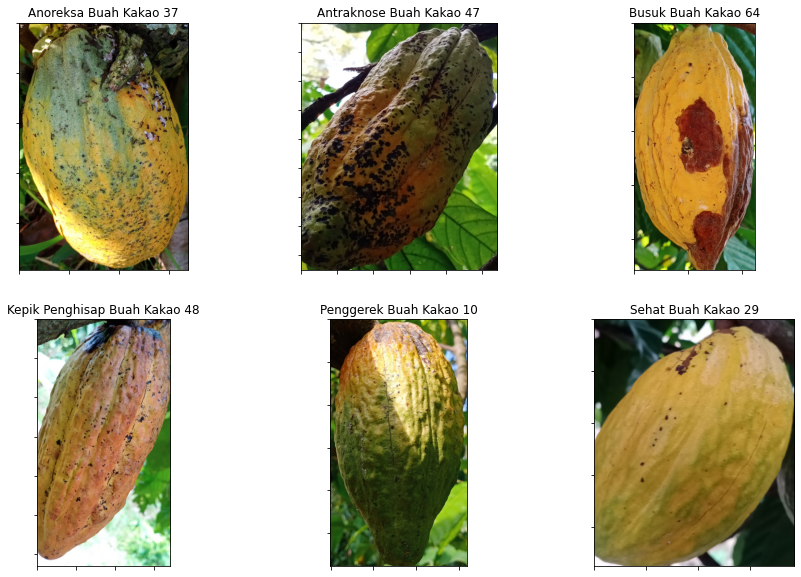

In [36]:
#membuat fungsi untuk merubah citra bgr hasil pembacaan opencv ke citra rgb untuk ditampilkan menggunkan matplotlib
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

#menampilkan sebuah gambar dari masing-masing folder data
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    ax = plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title(folder_data[i]+' '+str(idx))
plt.show()

In [38]:
#mengubah ukuran gambar ke ukuran 224 x 224
img_width = 224
img_height = 224
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

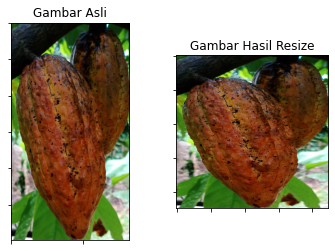

In [47]:
#menampilkan salah satu hasil perubahan ukuran gambar
img = images[3][30]
#print(img.shape)

resized_img = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
#print(resized_img.shape)

#gambar awal
ax1 = plt.subplot(1,2,1)
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.title('Gambar Asli')
ax1.set_yticklabels([])
ax1.set_xticklabels([])

#gambar setelah diubah ukuran
ax2 = plt.subplot(1,2,2)
plt.title('Gambar Hasil Resize')
plt.grid(False)
plt.imshow(cvtRGB(resized_img))
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.show()

In [58]:
#membagi data menjadi 70% data latih, 20% data validasi dan 10% data test
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

train_images = []
val_images = []
test_images = []
for imgs in resized_images:
    train, val_test = train_test_split(imgs, test_size = 1-train_ratio)
    val, test = train_test_split(val_test, test_size = test_ratio/(test_ratio + validation_ratio))
    train_images.append(train)
    val_images.append(val)
    test_images.append(test)


In [60]:
#membuat label data
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('Jumlah data latih:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(6):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('Jumlah data validasi', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(6):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

len_test_images = [len(imgs) for imgs in test_images]
print(len_test_images)
print('Jumlah data validasi', np.sum(len_test_images))
test_categories = np.zeros((np.sum(len_test_images)), dtype='uint8')
for i in range(6):
    if i is 0:
        test_categories[:len_test_images[i]] = i
    else:
        test_categories[np.sum(len_test_images[:i]):np.sum(len_test_images[:i+1])] = i

[35, 31, 39, 33, 36, 34]
Jumlah data latih: 208
[12, 11, 13, 11, 12, 11]
Jumlah data validasi 70
[12, 11, 14, 12, 13, 12]
Jumlah data validasi 74


In [61]:
tmp_train_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
train_images = np.array(tmp_train_imgs)

tmp_val_imgs = []
for imgs in val_images:
    tmp_val_imgs += imgs
val_images = np.array(tmp_val_imgs)

tmp_test_imgs = []
for imgs in test_images:
    tmp_test_imgs += imgs
test_images = np.array(tmp_test_imgs)

In [68]:
print('Sebelum Konversi')
print('data latih:', train_images.shape)
print('label data latih:', train_categories.shape)
print('data validasi:', val_images.shape)
print('label data validasi:', val_categories.shape)
print('data tes:', test_images.shape)
print('label data tes:', test_categories.shape)

categories = ['Anoreksa', 'Antraknose', 'Busuk', 'Kepik Penghisap Buah', 'Penggerek Buah', 'Sehat']


train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
test_data = test_images.astype('float32')

train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
test_labels = np_utils.to_categorical(test_categories, len(categories))

print('\nSetelah Konversi')
print('data latih:', train_data.shape)
print('label data validasi:', train_labels.shape)
print('data validasi:', val_data.shape)
print('label data latih:', val_labels.shape)
print('data tes:', test_data.shape)
print('label data tes:', test_labels.shape)

Sebelum Konversi
data latih: (208, 224, 224, 3)
label data latih: (208,)
data validasi: (70, 224, 224, 3)
label data validasi: (70,)
data tes: (74, 224, 224, 3)
label data tes: (74,)

Setelah Konversi
data latih: (208, 224, 224, 3)
label data validasi: (208, 6)
data validasi: (70, 224, 224, 3)
label data latih: (70, 6)
data tes: (74, 224, 224, 3)
label data tes: (74, 6)


In [71]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)
np.random.seed(seed)
np.random.shuffle(test_data)
np.random.seed(seed)
np.random.shuffle(test_labels)

In [72]:
train_data = train_data[:len(train_data)]
train_labels = train_labels[:len(train_data)]
val_data = val_data[:len(val_data)]
val_labels = val_labels[:len(val_data)]
test_data = test_data[:len(test_data)]
test_labels = test_labels[:len(test_data)]

print('bentuk data latih:', train_data.shape)
print('bentuk label data latih:', train_labels.shape)
print('bentuk data validasi:', val_data.shape)
print('bentuk label data validasi:', val_labels.shape)
print('bentuk data latih:', test_data.shape)
print('bentuk label data latih:', test_labels.shape)

bentuk data latih: (208, 224, 224, 3)
bentuk label data latih: (208, 6)
bentuk data validasi: (70, 224, 224, 3)
bentuk label data validasi: (70, 6)
bentuk data latih: (74, 224, 224, 3)
bentuk label data latih: (74, 6)


In [141]:
def create_mode_mobilenet():
  # Membuat model dasar (base model) dari pre-trained model MobileNet
  base_model = tensorflow.keras.applications.MobileNetV2(input_shape=(224, 224,3),
                                              include_top=False, 
                                              weights='imagenet')
  base_model.trainable = False
  model = tensorflow.keras.Sequential([
    base_model,
    tensorflow.keras.layers.GaussianNoise(0.25),  
    tensorflow.keras.layers.GlobalAveragePooling2D(),
    tensorflow.keras.layers.Dense(6, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adamax(lr=0.5), metrics=['acc'])
  return model

In [142]:
mobile_net_original = create_mode_mobilenet()
mobile_net_original.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
gaussian_noise_10 (GaussianN (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d_10  (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [154]:
#membuat generator
batch_size = 12

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=False,
    channel_shift_range = 0.1,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

In [144]:
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, 
                                                                    patience=6, verbose=2, mode='auto',
                                                                    min_lr=1e-7)

early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=5, verbose=1, mode='auto',
                                             baseline=None, restore_best_weights=True)

model_checkpoint = tensorflow.keras.callbacks.ModelCheckpoint("Model CNN Hasil Train/best_model_mobilenet_original.h5", monitor='val_acc', mode='max', verbose=2, save_best_only=True)

In [145]:
start = time.time()
EPOCHS= 30
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size + 1
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size + 1
mobile_net_original_info = mobile_net_original.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[reduce_lr, early_stop, model_checkpoint])
                    #initial_epoch = 10)
end = time.time()
duration = end - start
print ('\n Model membutuhkan waktu %0.2f detik (%0.1f menit) untuk melakukan pelatihan'%(duration, duration/60) )

Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 68.9357 - acc: 0.5577
Epoch 00001: val_acc improved from -inf to 0.92857, saving model to Model CNN Hasil Train/best_model_mobilenet_original.h5
18/18 [==============================] - 4s 230ms/step - loss: 68.9357 - acc: 0.5577 - val_loss: 1.1344 - val_acc: 0.9286
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 3.4767 - acc: 0.9279
Epoch 00002: val_acc did not improve from 0.92857
18/18 [==============================] - 3s 142ms/step - loss: 3.4767 - acc: 0.9279 - val_loss: 7.5190 - val_acc: 0.8714
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 1.8068 - acc: 0.9663
Epoch 00003: val_acc improved from 0.92857 to 0.97143, saving model to Model CNN Hasil Train/best_model_mobilenet_original.h5
18/18 [==============================] - 3s 160ms/step - loss: 1.8068 - acc: 0.9663 - val_loss: 1.0287 - val_acc: 0.9714
Epoch 4/30
18/18 [==============================] - ETA: 0s - loss: 0

In [174]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, len(history['acc'])+1, int(len(history['acc'])/10)))
  plt.title('Akurasi Pelatihan vs. Akurasi Validasi')
  plt.xlabel('Jumlah Epochs')
  plt.ylabel('Akurasi')
  plt.legend(['latih', 'validasi'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, len(history['loss'])+1, int(len(history['loss'])/10)))
  plt.title('Fungsi Loss Pelatihan vs. Fungsi Loss Validasi')
  plt.xlabel('Jumlah Epochs')
  plt.ylabel('Fungsi Loss')
  plt.legend(['latih', 'validasi'], loc='best')
  plt.savefig('grafik-pelatihan.png')
  plt.show()

Model CNN


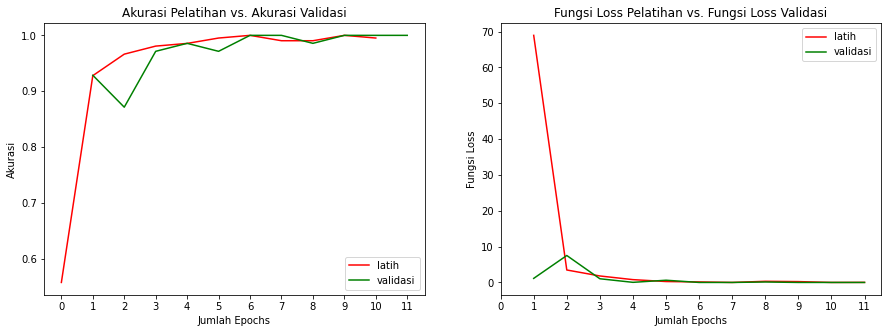

In [175]:
plot_model_history('Model CNN', mobile_net_original_info.history)

In [155]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow(
    test_data,
    test_labels,
    batch_size=batch_size
)

In [156]:
print(mobile_net_original.metrics_names)
print ('Evaluasi data training')
print(mobile_net_original.evaluate(train_generator))
print ('Evaluasi validasi data')
print(mobile_net_original.evaluate(val_generator))
print ('Evaluasi data test')
print(mobile_net_original.evaluate(test_generator)) 

['loss', 'acc']
Evaluasi data training
18/18 [==============================] - 2s 138ms/step - loss: 0.5086 - acc: 0.9952
[0.508639395236969, 0.995192289352417]
Evaluasi validasi data
6/6 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - acc: 1.0000
[0.0, 1.0]
Evaluasi data test
7/7 [==============================] - 0s 13ms/step - loss: 1.1186 - acc: 0.9730
[1.1185568571090698, 0.9729729890823364]


In [160]:
def predict(data, model):
  input = np.reshape(data, (1, img_width, img_height, 3))
  input = input/255.
  pred = model.predict(input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [161]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

Prediksi Data Test


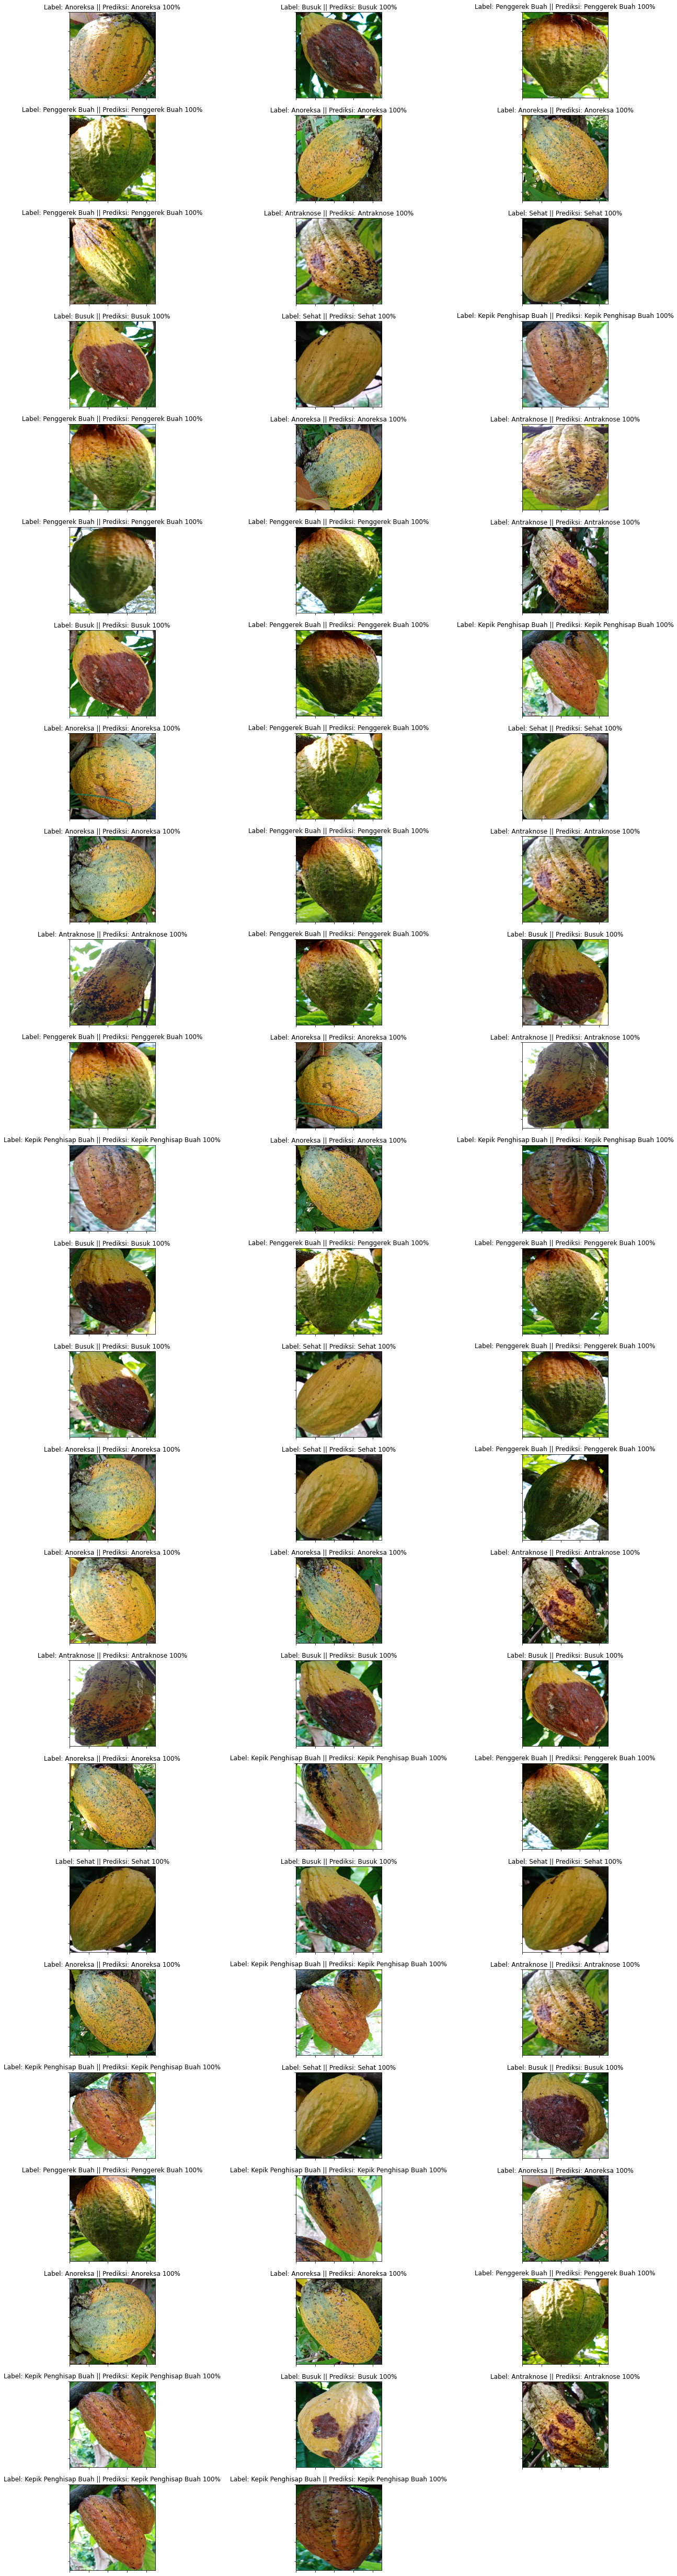

In [176]:
print("Prediksi Data Test")
plt.figure(figsize=(22,90))
for i in range(74):
  
  idx = np.random.randint(74)
  ax = plt.subplot(25,3,i+1)
  plt.imshow(cvtRGB(test_data.astype('uint8')[idx]))
  category_idx = return_name(test_labels[idx])
  
  pred, prob = predict(test_data[idx], mobile_net_original)
  plt.title('Label: %s || Prediksi: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])

plt.savefig('prediksi-data_test.pdf')
plt.show()

In [181]:
#Label yang benar
y_true = np.argmax(test_labels,axis=1)
print('label sebenarnya ',y_true)

#Label prediksi
Y_pred = mobile_net_original.predict(test_data/255)
y_pred = np.argmax(Y_pred, axis=1)
print('label hasil prediksi', y_pred)

label sebenarnya  [4 3 1 4 2 5 3 2 2 4 0 3 2 0 5 2 4 4 2 5 1 5 1 3 0 1 1 0 3 3 4 3 2 4 3 2 5
 4 3 5 5 0 0 5 4 4 1 1 0 2 0 3 2 0 1 2 0 1 3 2 1 5 5 4 2 1 5 4 4 0 3 5 2 0]
label hasil prediksi [4 3 1 4 2 5 3 2 2 4 0 3 2 0 5 2 4 4 2 5 1 5 1 3 0 1 1 0 3 3 4 3 2 4 3 2 5
 4 3 5 5 0 0 5 4 4 1 3 0 2 0 3 4 0 1 2 0 1 3 2 1 5 5 4 2 1 5 4 4 0 3 5 2 0]


Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   0.91 0.   0.09 0.   0.  ]
 [0.   0.   0.93 0.   0.07 0.  ]
 [0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]]


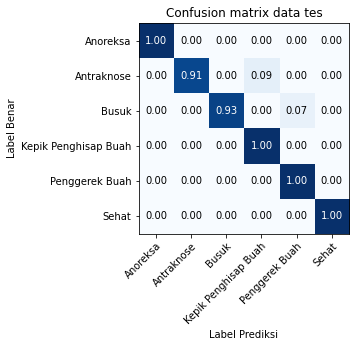

In [187]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=categories, normalize=True,
                      title='Confusion matrix data tes')

In [198]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred, average="macro")
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred, average="macro")
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred, average="macro")
print('F1 score: %f' % f1)

# confusion matrix
matrix = confusion_matrix(y_true, y_pred)
print(matrix)

Accuracy: 0.972973
Precision: 0.975275
Recall: 0.972944
F1 score: 0.973051
[[12  0  0  0  0  0]
 [ 0 10  0  1  0  0]
 [ 0  0 13  0  1  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 13  0]
 [ 0  0  0  0  0 12]]


In [200]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_true, y_pred)

print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

accuracy: 0.972972972972973
precision: [1.   1.   1.   0.92 0.93 1.  ]
recall: [1.   0.91 0.93 1.   1.   1.  ]
fscore: [1.   0.95 0.96 0.96 0.96 1.  ]
support: [12 11 14 12 13 12]
